In [1]:
track = 'https://envirocar.org/api/stable/tracks/642d15945244bc763cc65e0f'
streets = 'https://overpass-api.de/api/interpreter?data=[out%3Ajson][timeout%3A25]%3B%0A(%0A%20%20way["highway"~"^(motorway|trunk|primary|residential|tertiary|motorway_link|unclassified|service|secondary|secondary_link)%24"](48.7%2C9.01%2C48.735%2C9.13)%3B%0A)%3B%0Aout%20geom%3B'

In [2]:
pip install geopandas

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install contextily

Note: you may need to restart the kernel to use updated packages.


In [4]:
import geopandas as gp
from shapely.geometry import shape
import requests
import contextily as cx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.spatial import distance

In [5]:
response = requests.get(streets)
mystreets = response.json()['elements']
for d in mystreets:
    coords = []
    for p in d['geometry']:
        coords.append((p['lon'],p['lat']))
    data = {"type": "LineString", "coordinates": coords}
    d['geometry'] = shape(data)
gdf = gp.GeoDataFrame(mystreets).set_geometry('geometry')
#gdf.head()

In [6]:
mytrack = gp.read_file(track)
#mytrack

In [7]:
tmp_list = []
for x in range(0,mytrack.shape[0],4):
    tmp_list.append({
      'id': mytrack.loc[x,'id'],
      'time': mytrack.loc[x,'time'],
      'phenomenons': mytrack.loc[x,'phenomenons'],
      'geometry': mytrack.loc[x,'geometry']
     })
subTracks = gp.GeoDataFrame(tmp_list)
#subTracks

In [8]:
subTracks

,id,time,phenomenons,geometry
0,642d15945244bc763cc65e11,2023-04-05 06:30:31+00:00,{'Maximum Acceleration': {'value': 7.215007215...,POINT (9.01501 48.70868)
1,642d15a85244bc763cc65e1b,2023-04-05 06:30:47+00:00,"{'GPS Accuracy': {'value': 6.000000178813934, ...",POINT (9.01563 48.70837)
2,642d15a85244bc763cc65e1f,2023-04-05 06:30:56+00:00,"{'Rpm': {'value': 1473.794745773077, 'unit': '...",POINT (9.01683 48.70809)
3,642d15bf5244bc763cc65e26,2023-04-05 06:31:04+00:00,"{'GPS PDOP': {'value': 2.0311043560504913, 'un...",POINT (9.01824 48.70775)
4,642d15bf5244bc763cc65e2b,2023-04-05 06:31:12+00:00,"{'Rpm': {'value': 1361.6756262481213, 'unit': ...",POINT (9.01961 48.70744)
...,...,...,...,...
133,642d19f65244bc763cc660fd,2023-04-05 06:49:09+00:00,"{'GPS PDOP': {'value': 1.7, 'unit': 'precision...",POINT (9.11757 48.72712)
134,642d19f65244bc763cc66101,2023-04-05 06:49:17+00:00,"{'Rpm': {'value': 1991.0551168173552, 'unit': ...",POINT (9.11754 48.72668)
135,642d1a0c5244bc763cc66108,2023-04-05 06:49:25+00:00,"{'GPS PDOP': {'value': 1.8687755107879638, 'un...",POINT (9.11840 48.72653)
136,642d1a0c5244bc763cc6610d,2023-04-05 06:49:34+00:00,"{'GPS PDOP': {'value': 1.8841893255710602, 'un...",POINT (9.11881 48.72639)


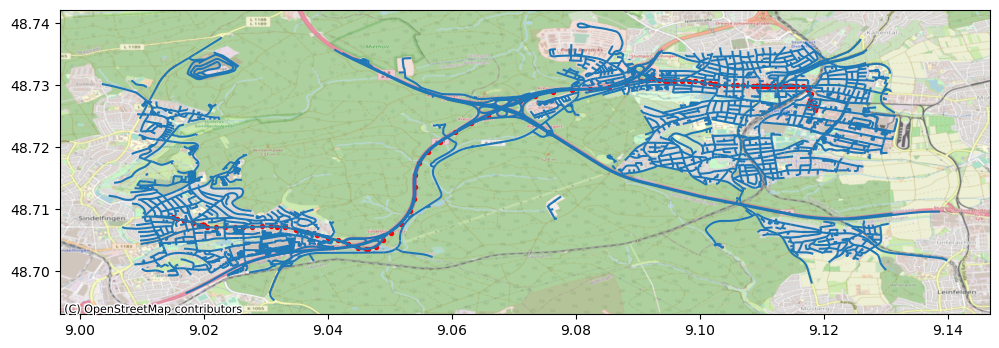

In [9]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
#worldMap = gp.read_file(gp.datasets.get_path("naturalearth_lowres"))
ax = subTracks.plot(ax=gdf.plot(), color='red', markersize=8)
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik, crs=4326)

In [10]:
puffer = subTracks.buffer(0.001)

In [11]:
puffergdf = gp.GeoDataFrame(geometry=puffer)

In [12]:
puffergdf.insert(0, "Id", range(1,1+len(puffergdf)))

In [13]:
tempStreets2 = gp.GeoDataFrame()
for puff in puffergdf.iterrows():
    tempStreets = []
    tempStreets = gp.overlay(gdf, gp.GeoDataFrame(geometry=[puff[1]['geometry']]), how='intersection')
    tempStreets['pufferId'] = puff[1]['Id']
    tempStreets2 = pd.concat([tempStreets2,tempStreets])

In [14]:
import shapely

In [15]:
snappedPoints = []
i=0
for index, row in tempStreets2.iterrows():
    activePoint = subTracks.loc[row['pufferId']-1]
    snappedPoints.append({
        'id': i,
        'pufferId': row['pufferId'],
        'pointId': activePoint['id'],
        'geometry': row['geometry'].interpolate(row['geometry'].project(activePoint.geometry))
     })
    i = i+1
snappedPointsGdf = gp.GeoDataFrame(snappedPoints)

In [16]:
#snappedPointsGdf.plot()

In [17]:
#snappedPointsGdf

,id,pufferId,pointId,geometry
0,0,1,642d15945244bc763cc65e11,POINT (9.01498 48.70779)
1,1,1,642d15945244bc763cc65e11,POINT (9.01428 48.70876)
2,2,1,642d15945244bc763cc65e11,POINT (9.01501 48.70865)
3,3,1,642d15945244bc763cc65e11,POINT (9.01528 48.70842)
4,4,1,642d15945244bc763cc65e11,POINT (9.01581 48.70813)
...,...,...,...,...
1818,1818,138,642d1a0c5244bc763cc66111,POINT (9.11863 48.72589)
1819,1819,138,642d1a0c5244bc763cc66111,POINT (9.11812 48.72609)
1820,1820,138,642d1a0c5244bc763cc66111,POINT (9.11853 48.72690)
1821,1821,138,642d1a0c5244bc763cc66111,POINT (9.11918 48.72637)


In [18]:
#puffergdf

,Id,geometry
0,1,"POLYGON ((9.01601 48.70868, 9.01600 48.70859, ..."
1,2,"POLYGON ((9.01663 48.70837, 9.01663 48.70827, ..."
2,3,"POLYGON ((9.01783 48.70809, 9.01782 48.70799, ..."
3,4,"POLYGON ((9.01924 48.70775, 9.01923 48.70765, ..."
4,5,"POLYGON ((9.02061 48.70744, 9.02060 48.70734, ..."
...,...,...
133,134,"POLYGON ((9.11857 48.72712, 9.11857 48.72702, ..."
134,135,"POLYGON ((9.11854 48.72668, 9.11854 48.72659, ..."
135,136,"POLYGON ((9.11940 48.72653, 9.11939 48.72643, ..."
136,137,"POLYGON ((9.11981 48.72639, 9.11981 48.72629, ..."


In [19]:
init_graph1 = {}
for index, puffrow in puffergdf.iterrows():
    tempPoints = snappedPointsGdf.loc[snappedPointsGdf['pufferId'] == puffrow['Id']]
    pointsToBasePoint = {}
    for index, tp in tempPoints.iterrows():
        pointsToBasePoint[tp['id']] = (tp['geometry'].x, tp['geometry'].y)
    init_graph1[puffrow['Id']] = pointsToBasePoint

In [20]:
#init_graph1

{1: {0: (9.014983821398285, 48.70778974989537),
  1: (9.014278343811197, 48.708764053093454),
  2: (9.01500615607195, 48.70865157929354),
  3: (9.0152789, 48.708415),
  4: (9.015813655353734, 48.70812559980504),
  5: (9.0149276, 48.7090562),
  6: (9.0153669, 48.7095824),
  7: (9.014985652036213, 48.70845279708325),
  8: (9.0152789, 48.708415),
  9: (9.015328194818006, 48.70858691561178),
  10: (9.0153368, 48.7086151)},
 2: {11: (9.0150941, 48.70778),
  12: (9.0153368, 48.7086151),
  13: (9.0152789, 48.708415),
  14: (9.015868368239083, 48.70820437347466),
  15: (9.0149276, 48.7090562),
  16: (9.0152789, 48.708415),
  17: (9.015627821314332, 48.70835177045267),
  18: (9.01529350045188, 48.70847363959463),
  19: (9.0165809, 48.7081383),
  20: (9.0164367, 48.708172),
  21: (9.0153368, 48.7086151)},
 3: {22: (9.0159283, 48.7082906),
  23: (9.0169793, 48.708042),
  24: (9.0170873, 48.7080179),
  25: (9.0170873, 48.7080179),
  26: (9.0165809, 48.7081383),
  27: (9.016825467758785, 48.7080791

In [21]:
d_graph = {}
d_graph[-1] = {}
for index, node in snappedPointsGdf.iterrows():
    d_graph[node['id']] = {}
lastIndex = -1
for index, puffrow in puffergdf.iterrows():
    tempPoints = snappedPointsGdf.loc[snappedPointsGdf['pufferId'] == puffrow['Id']]
    summe = 0
    for index, tp1 in tempPoints.iterrows():
        actSnappedPoint = (tp1['geometry'].x, tp1['geometry'].y)
        actBasePoint = (subTracks['geometry'].iloc[puffrow['Id']-1].x, subTracks['geometry'].iloc[puffrow['Id']-1].y)
        abstand = distance.euclidean(actSnappedPoint, actBasePoint)
        summe = summe + abstand
    if lastIndex == -1:
        for index, tp in tempPoints.iterrows():
            actSnappedPoint = (tp['geometry'].x, tp['geometry'].y)
            actBasePoint = (subTracks['geometry'].iloc[puffrow['Id']-1].x, subTracks['geometry'].iloc[puffrow['Id']-1].y)
            abstand = distance.euclidean(actSnappedPoint, actBasePoint)
            d_graph[-1][tp['id']] = 1-(abstand/summe)
    else:
        for i, secondCol in tempPoints.iterrows():
            for j, firstCol in (snappedPointsGdf.loc[snappedPointsGdf['pufferId'] == lastIndex]).iterrows():
                firstColPoint = (firstCol['geometry'].x, firstCol['geometry'].y)
                secColPoint = (secondCol['geometry'].x, secondCol['geometry'].y)
                abstand = distance.euclidean(firstColPoint, secColPoint)
                d_graph[firstCol['id']][secondCol['id']] = (1-(abstand/summe)) * 100
    lastIndex = puffrow['Id']
for index, pts in snappedPointsGdf.loc[snappedPointsGdf['pufferId'] == puffergdf['Id'].max()].iterrows():
    d_graph[pts['id']][-2] = 0

In [22]:
#d_graph

In [23]:
els = list(d_graph.items())
els[-3]

(1820, {-2: 0})